In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
import string
import matplotlib.pyplot as plt
# import cv2
import os
from sklearn.metrics import accuracy_score

import torch
from transformers import BertTokenizer
import os
# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Parameters for BERT model and tokenization
bert_path = "bert-base-uncased"  # Use the Hugging Face model

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained(bert_path)

def get_df(file):
    return pd.read_csv(file,sep = '\t')

train_df = get_df('train_posts.txt')
test_df = get_df('test_posts.txt')

def return_first_image(row):
    return row['imageId(s)'].split(',')[0].strip()

tqdm.pandas()
train_df['first_image_id'] = train_df.progress_apply (lambda row: return_first_image(row),axis=1)
test_df['first_image_id'] = test_df.progress_apply (lambda row: return_first_image(row),axis=1)

from os import listdir

images_train_dataset = [i for i in train_df['first_image_id'].tolist()]
images_train_folder = [i.split('.')[0].strip() for i in listdir('images_train/')]
images_train_not_available = set(images_train_dataset)-set(images_train_folder)
images_train_not_available

images_test_dataset = [i.split(',')[0].strip() for i in test_df['first_image_id'].tolist()]
images_test_folder = [i.split('.')[0].strip() for i in listdir('images_test/')]
images_test_not_available = set(images_test_dataset)-set(images_test_folder)
images_test_not_available

train_df = train_df[~train_df['first_image_id'].isin(images_train_not_available)]
test_df = test_df[~test_df['first_image_id'].isin(images_test_not_available)]

train_text = train_df['tweetText'].tolist()
test_text = test_df['tweetText'].tolist()

train_images = [i for i in train_df['first_image_id'].tolist()]
test_images = [i.split(',')[0].strip() for i in test_df['imageId(s)'].tolist()]

trainY = train_df['label'].tolist()
trainY = [1 if i=='real' else 0 for i in trainY]

testY = test_df['label'].tolist()
testY = [1 if i=='real' else 0 for i in testY]

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|███████████████████████████████████| 3755/3755 [00:00<00:00, 103915.99it/s]


maximum length: 901


(array([   0.,    4.,  327.,  532.,  755.,  760.,  843.,  791.,  904.,
        2534., 2379.,  775., 1462., 1113., 1047.,   17.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 12, 15, 16, 18, 20, 25, 30]),
 <BarContainer object of 16 artists>)

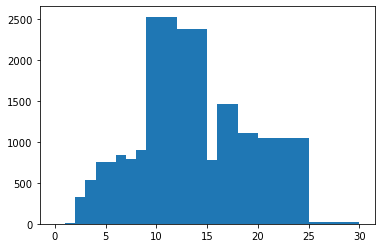

In [2]:
len(train_text),len(train_images),len(trainY),len(test_text),len(test_images),len(testY)

# calculate the maximum document length
def max_length(lines):
    return max([len(s.split()) for s in lines])

print("maximum length:", max_length(train_text))
plt.hist([len(s.split()) for s in train_text],bins=[0,1,2,3,4,5,6,7,8,9,12,15,16,18,20,25,30])

In [3]:
l=[len(s.split()) for s in train_text]
count=0.0
for i in l:
    if i>22:
        count+=1
print(count,len(l))
print(count/len(l))

128.0 14258
0.008977416187403563


# Text Part

In [4]:
import numpy as np
from transformers import BertTokenizer
from tqdm import tqdm  # Import tqdm for progress tracking
import torch

class PaddingInputExample:
    """Fake example so the num input examples is a multiple of the batch size."""
    pass  # No need for methods or properties; just a marker class

class InputExample:
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs an InputExample.

        Args:
            guid: Unique id for the example.
            text_a: string. The untokenized text of the first sequence.
            text_b: (Optional) string. The untokenized text of the second sequence.
            label: (Optional) string. The label of the example.
        """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

def create_tokenizer():
    """Instantiate the mBERT tokenizer."""
    return BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""
    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)

    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)

    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label

def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""
    input_ids, input_masks, segment_ids, labels = [], [], [], []

    for example in tqdm(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)

    return (
        torch.tensor(input_ids),          # Use torch tensors
        torch.tensor(input_masks),        # Use torch tensors
        torch.tensor(segment_ids),        # Use torch tensors
        torch.tensor(labels).reshape(-1, 1)  # Use torch tensors
    )

def convert_text_to_examples(texts, labels):
    """Create InputExamples"""
    input_examples = []
    for text, label in zip(texts, labels):
        input_examples.append(
            InputExample(guid=None, text_a=" ".join(text), text_b=None, label=label)
        )
    return input_examples

# Instantiate the tokenizer
tokenizer = create_tokenizer()

# Convert data to InputExample format
# Assuming train_text and trainY, test_text and testY are already defined
train_examples = convert_text_to_examples(train_text, trainY)
test_examples = convert_text_to_examples(test_text, testY)

# Convert to features
train_input_ids, train_input_masks, train_segment_ids, trainY = convert_examples_to_features(tokenizer, train_examples, max_seq_length=128)
test_input_ids, test_input_masks, test_segment_ids, testY = convert_examples_to_features(tokenizer, test_examples, max_seq_length=128)

# Now you can proceed to use `train_input_ids`, `train_input_masks`, `train_segment_ids`, and `trainY`
# for training your model in PyTorch


/opt/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Converting examples to features: 100%|████| 1923/1923 [00:01<00:00, 1350.06it/s]


In [5]:
import torch
import torch.nn as nn
from transformers import BertModel

class MBertLayer(nn.Module):
    def __init__(self, bert_path="bert-base-multilingual-cased", n_fine_tune_layers=1):
        super(MBertLayer, self).__init__()
        self.n_fine_tune_layers = n_fine_tune_layers
        self.output_size = 768  # Default output size of BERT

        # Load pre-trained mBERT model
        self.bert = BertModel.from_pretrained(bert_path)

        # Set all layers to non-trainable initially
        for param in self.bert.parameters():
            param.requires_grad = False

        # Unfreeze the last `n_fine_tune_layers` layers
        if n_fine_tune_layers > 0:
            for layer in self.bert.encoder.layer[-n_fine_tune_layers:]:
                for param in layer.parameters():
                    param.requires_grad = True

        # Optional: Linear layer to reduce dimensionality (commented for flexibility)
        # self.fc = nn.Linear(self.output_size, 256)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        # Get the outputs from BERT
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True  # Ensures outputs are returned as a dictionary
        )

        # Extract the pooled output (representation of [CLS] token)
        pooled_output = outputs.pooler_output

        # Optional: Reduce dimensionality using a linear layer
        # reduced_output = self.fc(pooled_output)

        return pooled_output

# Example usage:
# mb_layer = MBertLayer(bert_path="bert-base-multilingual-cased", n_fine_tune_layers=10)

# # Example input IDs and attention mask
# input_ids = torch.tensor([[101, 2009, 2003, 1037, 3071, 102]])  # Example input
# attention_mask = torch.tensor([[1, 1, 1, 1, 1, 1]])

# output = mb_layer(input_ids=input_ids, attention_mask=attention_mask)
# print(output.shape)  # Should print torch.Size([1, 768])



In [6]:
import torch
from tqdm import tqdm  # Import tqdm for progress tracking

# Initialize feature extractor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mb_layer = MBertLayer(bert_path="bert-base-multilingual-cased", n_fine_tune_layers=10).to(device)

# # Move input data to GPU
train_input_ids = train_input_ids.to(device)
train_input_masks = train_input_masks.to(device)
train_segment_ids = train_segment_ids.to(device)

# Move test data to GPU
# train_input_ids = test_input_ids.to(device)
# train_input_masks = test_input_masks.to(device)
# train_segment_ids = test_segment_ids.to(device)

# Process in batches with mixed precision
batch_size = 32  # Adjust based on VRAM usage
features = []

with torch.no_grad(): #, torch.cuda.amp.autocast():
    for i in tqdm(range(0, len(train_input_ids), batch_size),desc='Processing Text'):
        batch_ids = train_input_ids[i:i+batch_size]
        batch_masks = train_input_masks[i:i+batch_size]
        batch_segments = train_segment_ids[i:i+batch_size]

        batch_features = mb_layer(batch_ids, batch_masks, batch_segments)
        features.append(batch_features.cpu())  # Move to CPU to free up GPU memory

# Concatenate all batches for final output
features = torch.cat(features)
torch.save(features, "mbert_features_train.pt")
print(features.shape)



Processing Text: 100%|████████████████████████| 446/446 [22:00<00:00,  2.96s/it]

torch.Size([14258, 768])


# Image part

In [7]:
length = 224
width = 224
channels = 3

# length = 64
# width = 64
# channels = 3

In [8]:
train_imagesX = np.load('train_imagesX.npy')
test_imagesX = np.load('test_imagesX.npy')

train_imagesX = np.rollaxis(train_imagesX, 3, 1)
test_imagesX = np.rollaxis(test_imagesX,3,1)

# Alternatively, using from_numpy which preserves the original data type
train_imagesX = torch.from_numpy(train_imagesX).float()
test_imagesX = torch.from_numpy(test_imagesX).float()

In [9]:
from torchvision import models
# Define the main NewsModel
class image_feature_extract(nn.Module):
    def __init__(self):
        super(image_feature_extract, self).__init__()
       
        # Image model with VGG-19 feature extractor
        self.vgg_base = models.vgg19(pretrained=True)
        self.vgg_base.classifier = nn.Identity()  # Remove classifier for feature extraction
        for param in self.vgg_base.parameters():
            param.requires_grad = False  # Freeze VGG base layers
    
    def forward(self,image):

        # VGG-19 forward pass
        image_features = self.vgg_base(image)
        image_flatten = image_features.view(image_features.size(0), -1)  # Flatten for fully connected layers
        return image_flatten

# Model

In [10]:
import torch.nn as nn
from torchvision import models
# Define the main NewsModel
class NewsModel(nn.Module):
    def __init__(self, params):
        super(NewsModel, self).__init__()

        text_hidden_layers = []
        input_size = 768
        for _ in range(params['text_no_hidden_layer']):
            text_hidden_layers.append(nn.Linear(input_size, params['text_hidden_neurons']))
            text_hidden_layers.append(nn.ELU())
            text_hidden_layers.append(nn.Dropout(params['dropout']))
            input_size = params['text_hidden_neurons']
        self.text_hidden_layers = nn.Sequential(*text_hidden_layers)
        
        self.text_repr = nn.Linear(input_size, params['repr_size'])
        

        vis_hidden_layers = []
        input_size = 512*7*7
        for _ in range(params['vis_no_hidden_layer']):
            vis_hidden_layers.append(nn.Linear(input_size, params['vis_hidden_neurons']))
            vis_hidden_layers.append(nn.ELU())
            vis_hidden_layers.append(nn.Dropout(params['dropout']))
            input_size = params['vis_hidden_neurons']
        self.vis_hidden_layers = nn.Sequential(*vis_hidden_layers)

        self.visual_repr = nn.Linear(input_size, params['repr_size'])
        
        # Final combined classifier
        combined_size = 2 * params['repr_size']
        final_hidden_layers = []
        for _ in range(params['final_no_hidden_layer']):
            final_hidden_layers.append(nn.Linear(combined_size, params['final_hidden_neurons']))
            final_hidden_layers.append(nn.ELU())
            final_hidden_layers.append(nn.Dropout(params['dropout']))
            combined_size = params['final_hidden_neurons']
            
        self.final_hidden_layers = nn.Sequential(*final_hidden_layers)

        self.classifier = nn.Linear(combined_size, 1)  # Binary classification
    
    def forward(self,features, image_features):
        # BERT forward pass
        #text_output = self.bert_layer(input_ids, attention_mask, token_type_ids)
        
        text_output = self.text_hidden_layers(features)
        text_repr = self.text_repr(text_output)
        
        # VGG-19 forward pass
        image_features = image_features
        #image_flatten = image_features.view(image_features.size(0), -1)  # Flatten for fully connected layers
        #image_output = self.vis_hidden_layers(image_flatten)
        image_output = self.vis_hidden_layers(image_features )
        visual_repr = self.visual_repr(image_output)
        
        # Concatenate text and visual representations
        # print(text_repr.shape)
        # print(visual_repr.shape)
        combined_repr = torch.cat((text_repr, visual_repr), dim=1)
        combined_output = self.final_hidden_layers(combined_repr)
        
        # Final classifier layer
        prediction = torch.sigmoid(self.classifier(combined_output))
        
        return prediction

In [15]:
import torch

# Check if CUDA is available
is_cuda_available = torch.cuda.is_available()
print(f"Is CUDA available? {is_cuda_available}")

# If CUDA is available, get the current device
if is_cuda_available:
    current_device = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(current_device)
    print(f"Current GPU device: {device_name}")
else:
    current_device = torch.device("cpu")
    print("Using CPU")


Is CUDA available? False
Using CPU


In [16]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split

def training(params,train_ratio,batch_size,lr=0.001,weight_decay=1e-5,num_epochs=20):


    # Load saved features
    features = torch.load("mbert_features_train.pt")
    image_features = torch.load("image_features.pt")
    labels = trainY

    # Check the sizes of the loaded tensors
    print("Features shape:", features.shape)
    print("Image features shape:", image_features.shape)
    print("Labels shape:", labels.shape)

    # Create a dataset
    dataset = TensorDataset(features, image_features, labels)

    # Define the split ratio for training and validation
    train_ratio = train_ratio #0.7
    train_size = int(train_ratio * len(dataset))
    val_size = len(dataset) - train_size

    # Split the dataset into training and validation sets
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create DataLoaders for training and validation
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Create the model
    model_adam = NewsModel(params).to(current_device)

    # Set the learning rate and optimizer
    fixed_lr = lr   # Set the desired learning rate
    optimizer = optim.Adam(model_adam.parameters(), lr=fixed_lr,weight_decay=weight_decay)
    criterion = nn.BCELoss()
    train_losses = []
    val_losses = []
    # Training loop
    num_epochs = num_epochs # Set the desired number of epochs
    for epoch in range(num_epochs):
        model_adam.train()  # Set the model to training mode
        for batch_features, batch_image_features, batch_labels in train_loader:
            # Move inputs to device
            device = next(model_adam.parameters()).device
            batch_features, batch_image_features, batch_labels = (
                batch_features.to(device),
                batch_image_features.to(device),
                batch_labels.float().to(device)
            )

            # Forward pass
            outputs = model_adam(batch_features, batch_image_features)
            outputs = outputs.unsqueeze(1)
            loss = criterion(outputs.squeeze(), batch_labels.squeeze())

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation loop
        model_adam.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():  # No gradient tracking for validation
            for val_features, val_image_features, val_labels in val_loader:
                val_features, val_image_features, val_labels = (
                    val_features.to(device),
                    val_image_features.to(device),
                    val_labels.float().to(device)
                )

                # Forward pass
                val_outputs = model_adam(val_features, val_image_features)
                val_outputs = val_outputs.unsqueeze(1)
                val_loss += criterion(val_outputs.squeeze(), val_labels.squeeze()).item()

        # Calculate average validation loss
        avg_val_loss = val_loss / len(val_loader)
        
        # Print results for the current epoch
        print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Val Loss: {avg_val_loss:.4f}")
        train_losses.append(loss.item())
        val_losses.append(avg_val_loss)

    #After the training loop, you can save the model or perform evaluation as needed

    # Optionally, visualize the losses later
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), np.array(train_losses), label='Training Loss', marker='o')
    plt.plot(range(1, num_epochs + 1),np.array(val_losses), label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()
    return model_adam

    

In [17]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
def testing(model):


    # Load saved features
    test_features = torch.load("mbert_features_test.pt")
    test_image_features = torch.load("image_features_test.pt")
    test_labels = testY  # Assuming testY is defined elsewhere
    device = current_device
    # Create a test dataset and dataloader
    test_dataset = TensorDataset(test_features, test_image_features, test_labels)
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

    model_adam=model
    # Set the model to evaluation mode
    model_adam.eval()
    test_loss = 0.0
    criterion = nn.BCELoss()  # Using the same loss function as in training

    # Initialize metrics
    total_samples = 0

    # Initialize accumulators for overall metrics
    all_true_labels = []
    all_predicted_labels = []
    test_loss = 0.0  # Resetting test_loss to use for averaging later

    with torch.no_grad():  # Disable gradient calculations for testing
        for features, image_features, labels in test_loader:
            # Move inputs to device
            features, image_features, labels = (
                features.to(device),
                image_features.to(device),
                labels.float().to(device)  # Ensure labels are floats for BCELoss
            )

            # Forward pass
            outputs = model_adam(features, image_features)
            outputs = outputs.unsqueeze(1)  # Adjusting dimensions if needed
            
            # Calculate the batch test loss
            loss = criterion(outputs.squeeze(), labels.squeeze())
            test_loss += loss.item()  # Accumulate loss
            total_samples += labels.size(0)  # Count total samples

            # Convert probabilities to binary predictions (assuming output is in [0, 1])
            predicted_labels = (outputs.squeeze().cpu().numpy() > 0.5).astype(int)  # Apply threshold
            true_labels = labels.squeeze().cpu().numpy()  # Use correct variable name

            # Store the true and predicted labels for overall metrics
            all_true_labels.extend(true_labels)
            all_predicted_labels.extend(predicted_labels)

    # Convert to numpy arrays for metric calculations
    all_true_labels = np.array(all_true_labels)
    all_predicted_labels = np.array(all_predicted_labels)

    # Calculate overall metrics
    accuracy = accuracy_score(all_true_labels, all_predicted_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(all_true_labels, all_predicted_labels, average='binary')

    # Calculate the average test loss
    avg_test_loss = test_loss / len(test_loader)  # This gives you the average loss per batch

    # Print overall metrics
    print(f"Average Test Loss: {avg_test_loss:.4f}")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Overall Precision: {precision:.4f}")
    print(f"Overall Recall: {recall:.4f}")
    print(f"Overall F1 Score: {f1:.4f}")

    from sklearn.metrics import precision_recall_curve, average_precision_score
    import matplotlib.pyplot as plt

    # Calculate precision, recall, and thresholds
    precision, recall, thresholds = precision_recall_curve(all_true_labels, all_predicted_labels)

    # Calculate Average Precision (AP) score
    average_precision = average_precision_score(all_true_labels, all_predicted_labels)

    # Plot the Precision-Recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'AP = {average_precision:.2f}', color='b')

    # Add plot details
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

    # Compute the confusion matrix
    cm = confusion_matrix(all_true_labels, all_predicted_labels)

    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)

    # Customize the plot
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()




Features shape: torch.Size([14258, 768])
Image features shape: torch.Size([14258, 25088])
Labels shape: torch.Size([14258, 1])
Epoch: 1/20, Loss: 0.1915, Val Loss: 0.1819
Epoch: 2/20, Loss: 0.0800, Val Loss: 0.0807
Epoch: 3/20, Loss: 0.1119, Val Loss: 0.0882
Epoch: 4/20, Loss: 0.0453, Val Loss: 0.1219
Epoch: 5/20, Loss: 0.0710, Val Loss: 0.1381
Epoch: 6/20, Loss: 0.0667, Val Loss: 0.0949
Epoch: 7/20, Loss: 0.0302, Val Loss: 0.0943
Epoch: 8/20, Loss: 0.1627, Val Loss: 0.0942
Epoch: 9/20, Loss: 0.0406, Val Loss: 0.1222
Epoch: 10/20, Loss: 0.0648, Val Loss: 0.1166
Epoch: 11/20, Loss: 0.0483, Val Loss: 0.0701
Epoch: 12/20, Loss: 0.0885, Val Loss: 0.1072
Epoch: 13/20, Loss: 0.0405, Val Loss: 0.0660
Epoch: 14/20, Loss: 0.0558, Val Loss: 0.1039
Epoch: 15/20, Loss: 0.0391, Val Loss: 0.0623
Epoch: 16/20, Loss: 0.0138, Val Loss: 0.0575
Epoch: 17/20, Loss: 0.0867, Val Loss: 0.0535
Epoch: 18/20, Loss: 0.0337, Val Loss: 0.0396
Epoch: 19/20, Loss: 0.0287, Val Loss: 0.0258
Epoch: 20/20, Loss: 0.0177,

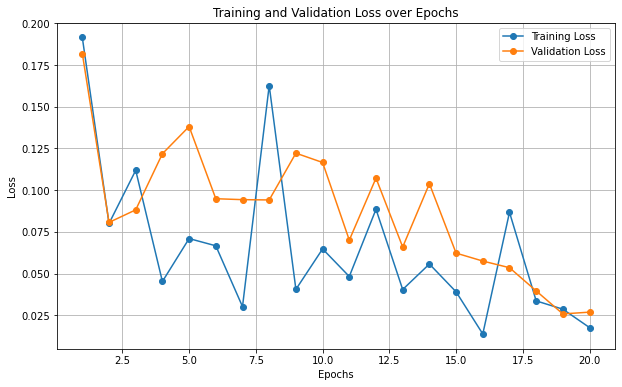

Average Test Loss: 0.6521
Overall Accuracy: 0.8861
Overall Precision: 0.8474
Overall Recall: 0.9983
Overall F1 Score: 0.9167


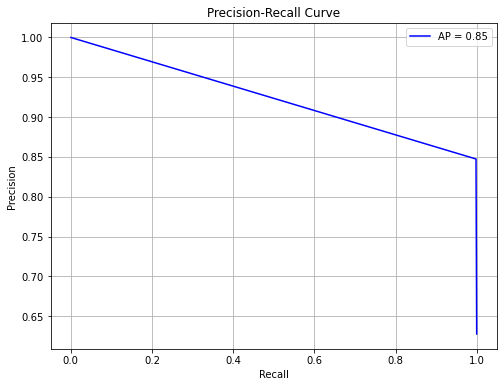

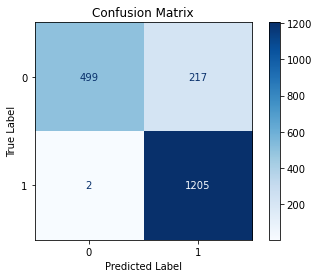

In [18]:
#provide good result for mBert

params = {

    'text_no_hidden_layer':2,
    'text_hidden_neurons':768,   #'text_hidden_neurons':768,
    'dropout':0.4,
    'repr_size':32,
    'vis_no_hidden_layer':2,
    'vis_hidden_neurons':2742,   #'vis_hidden_neurons':2742,
    'final_no_hidden_layer':7,
    'final_hidden_neurons':35,
    'optimizer':['adam'],
}
model=training(params,train_ratio=0.8,batch_size=256,lr=0.001,weight_decay=0.0001,num_epochs=20)
testing(model)

In [1]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Confusion matrix (values taken from the example you provided)
# Format: [[TN, FP], [FN, TP]]
confusion_matrix = [[499, 217], [2, 1205]]

# Extract values
TN, FP = confusion_matrix[0]
FN, TP = confusion_matrix[1]

# Total samples (from confusion matrix)
total_samples = sum([sum(row) for row in confusion_matrix])

# Overall Accuracy (given)
accuracy = 0.8861  # Example accuracy value

# Precision, Recall, and F1 for class 0 (Negative Class)
precision_0 = TN / (TN + FP) if (TN + FP) != 0 else 0
recall_0 = TN / (TN + FN) if (TN + FN) != 0 else 0
f1_0 = 2 * (precision_0 * recall_0) / (precision_0 + recall_0) if (precision_0 + recall_0) != 0 else 0

# Precision, Recall, and F1 for class 1 (Positive Class)
precision_1 = TP / (TP + FP) if (TP + FP) != 0 else 0
recall_1 = TP / (TP + FN) if (TP + FN) != 0 else 0
f1_1 = 2 * (precision_1 * recall_1) / (precision_1 + recall_1) if (precision_1 + recall_1) != 0 else 0

# Display results
print("Class 0 (Negative) Metrics:")
print(f"Precision: {precision_0:.4f}")
print(f"Recall: {recall_0:.4f}")
print(f"F1 Score: {f1_0:.4f}")

print("\nClass 1 (Positive) Metrics:")
print(f"Precision: {precision_1:.4f}")
print(f"Recall: {recall_1:.4f}")
print(f"F1 Score: {f1_1:.4f}")

# Optional: Using sklearn's built-in functions to verify
y_true = [0] * (TN + FN) + [1] * (FP + TP)
y_pred = [0] * TN + [1] * FP + [0] * FN + [1] * TP

# Sklearn verification
precision_sklearn_0 = precision_score(y_true, y_pred, pos_label=0)
recall_sklearn_0 = recall_score(y_true, y_pred, pos_label=0)
f1_sklearn_0 = f1_score(y_true, y_pred, pos_label=0)

precision_sklearn_1 = precision_score(y_true, y_pred, pos_label=1)
recall_sklearn_1 = recall_score(y_true, y_pred, pos_label=1)
f1_sklearn_1 = f1_score(y_true, y_pred, pos_label=1)

# Sklearn comparison
print("\nSklearn Verification (Class 0 and Class 1):")
print(f"Class 0 - Precision: {precision_sklearn_0:.4f}, Recall: {recall_sklearn_0:.4f}, F1: {f1_sklearn_0:.4f}")
print(f"Class 1 - Precision: {precision_sklearn_1:.4f}, Recall: {recall_sklearn_1:.4f}, F1: {f1_sklearn_1:.4f}")


/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Class 0 (Negative) Metrics:
Precision: 0.6969
Recall: 0.9960
F1 Score: 0.8200

Class 1 (Positive) Metrics:
Precision: 0.8474
Recall: 0.9983
F1 Score: 0.9167

Sklearn Verification (Class 0 and Class 1):
Class 0 - Precision: 0.9960, Recall: 0.9960, F1: 0.9960
Class 1 - Precision: 0.9986, Recall: 0.9986, F1: 0.9986
